## MSDS 7331: Data Mining
## Lab 2:  Classification & Regression - Group 4

#### Paticia Attah
#### Linda Eliasen

##### Overview

The H-1B Dataset selected for this project contains data from employers Labor Condition Applications and the case certification determinations processed by the Office of Foreign Labor Certification (OFLC) where the date of the determination was issued on or after October 1, 2016 and on or before June 30, 2017.

The Labor Condition Application (LCA) is a document that a prospective H-1B employer files with the U.S. Department of Labor Employment and Training Administration (DOLETA) when it seeks to employ non-immigrant workers at a specific job occupation in an area of intended employment for no more than three years for the intital approval. Total stay is limited to 6 years.

An H-1B visa is issued for a specialty occupation, requiring theoretical and practical application of a body of specialized knowledge along with a bachelors degree or its equivalent. The prospective H-1B employee must also hold a U.S. bachelor's or higher degree, or the equivalent.

Both Classification and Regression Modeling will be conducted.

<b> Classification Goal</b>

The goal of the classification model is to predict the two classes effectively (denied and certified). The dataset is imbalanced where most of the target values are certified so the challenge will be to predict the denied category correctly. The most severe problem that can occur would be the prediction that a denied candidate would be certified. This could lead to a delayed project and would cost the company its reputation or may also lead to a completed project that is below expectation due to inexperienced employees, and eventually loss of company profit. The metric that would determine this would be the recall score of the denied category. <br>


<b>Regression Goal</b>

The goal is to predict the certification processing time, in days, of the LCA and identify the top features driving the prediction. 

Regression measures include Mean Average Error (MAE), Mean Averge Percent Error (MAPE) and Root Mean Square Error (RSME), which will be compared among all models to determine which model is best for the task at hand.

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics as mt
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from IPython.html import widgets 

from time import time

import pandas as pd
import statsmodels.api as sm 
import numpy as np
import random
from mlxtend.evaluate import paired_ttest_5x2cv

import math

import warnings
warnings.filterwarnings("ignore")

/Users/patriciaattah/opt/anaconda3/envs/ML7331/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedShuffleSplit,KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,plot_confusion_matrix,recall_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
#import numpy as np
import random
#from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.classifier import ROCAUC,ClassPredictionError,ConfusionMatrix

# Data Preparation Part 1

This is the initial dataset that is divided into 3 groups(certified, certified-withdrawn, denied), however the targer categories were reduced to certified and denied because the certified withdrawn is ultimately certified aplications that the employer decided to withdraw this does not make any impact on our goal of finding features that cause applications to be certified or denied. This data has been cleaned and outliers removed from the previous lab. Also the data was very unbalanced with majority of the applications being certified so measures were taken to take the imbalance into consideration.

###  Steps for the data preparation
1. Creating Dummy variables and dropping unnecesary variables
3. Imputation of missing values
4. Reducing the certified values to create a less unbalanced dataset

<AxesSubplot:title={'center':'count (target)'}>

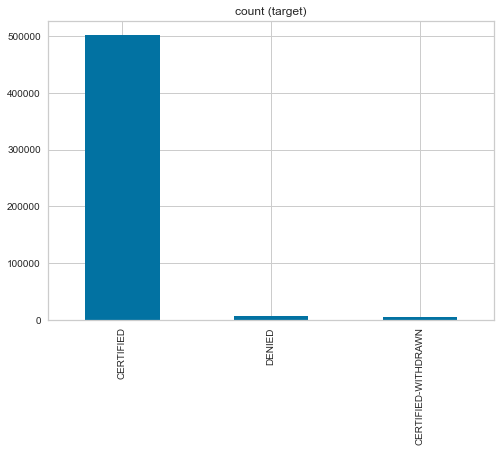

In [3]:
df = pd.read_csv ('uncleaned_Visa_Data.csv')
df = df.sample(frac = 1) 
df['CASE_STATUS'].value_counts().plot(kind='bar', title='count (target)')

# Data Preparation Part 1
### Step 1: Creating Dummy variables and dropping unnecesary variables
At this point we are removing the categorical columns and replacing them with dummy variable that will 0,1 value for the model. Out target variable is 1 which means certified and 0 which specifies denied. In this phase we also removed some unnecesarry varibale incuding the unit of pay and wage unit of pay which specifies how the salary was recorded for an example weekly, bi-weekly monthly.

Some features that were dropped include variables that had very large number of categories including WORKSITE_CITY, EMPLOYER_NAME, JOB_TITLE these variables had numerous categories and may not have substantial effect on the predicting the dependent variable since the categories were so many in number.

The next set of variable that were removed were some created variables that specified the unit that the pay was recorded in either bi-weekly, weekly or monthly as this would not impact the have any explanatory value if found significant these features were PW_UNIT_OF_PAY, WAGE_UNIT_OF_PAY. Also PREVAILING_WAGE, and WAGE_RATE_OF_PAY were dollar amounts of the pay that was being oaid by the employer and the currnet market rate of pay these needed to be removed because they were not recorded with a uniform value for example some were recorded with the bi-weekly rate and some were recorded with annual amout so since the dollar amount are not uniform it will distort the predicting effciency of the model.


After the necccessary variables are removed one hot encoding is used on the variables with multiple categories (having less than 50 categories). These values are then joined to the original data set. The data is then divided into the target variable and the independent variables. The data is then scaled only the independent variables.

In [4]:
WILLFUL_VIOLATOR = pd.get_dummies(df.WILLFUL_VIOLATOR, prefix='WILL_VIOL',drop_first=True)
df = pd.concat([df, WILLFUL_VIOLATOR], axis=1)

SOC_GROUP = pd.get_dummies(df['SOC_GROUP'],drop_first=True)
df = pd.concat([df, SOC_GROUP], axis=1)

PW_WAGE_LEVEL = pd.get_dummies(df.PW_WAGE_LEVEL, prefix='PW_LEVEL',drop_first=True)
df = pd.concat([df, PW_WAGE_LEVEL], axis=1)

AGENT_REPRESENTING_EMPLOYER = pd.get_dummies(df.AGENT_REPRESENTING_EMPLOYER, prefix='AGENT_REP',drop_first=True)
df = pd.concat([df, AGENT_REPRESENTING_EMPLOYER], axis=1)  

H1B_DEPENDENT = pd.get_dummies(df.H1B_DEPENDENT, prefix='H1B_DEP',drop_first=True)
df = pd.concat([df, H1B_DEPENDENT], axis=1)

LABOR_CON_AGREE = pd.get_dummies(df.LABOR_CON_AGREE, prefix='LABOR_CON_AGREE',drop_first=True)
df = pd.concat([df, LABOR_CON_AGREE], axis=1)

SUPPORT_H1B = pd.get_dummies(df.SUPPORT_H1B, prefix='SUPPORT_H1B',drop_first=True)
df = pd.concat([df, SUPPORT_H1B], axis=1)

In [5]:
df1 = df.drop(['EMPLOYER_STATE','DECISION_DATE','CASE_SUBMITTED','CASE_NUMBER',
           'Unnamed: 0','WORKSITE_CITY','EMPLOYER_NAME','PW_UNIT_OF_PAY',
            'EMPLOYER_CITY', 'WORKSITE_STATE', 'SOC_GROUP_Code','SOC_NAME','JOB_TITLE',
            'WAGE_UNIT_OF_PAY','PW_UNIT_OF_PAY','PREVAILING_WAGE','SOC_CODE',
            'WILLFUL_VIOLATOR','PW_WAGE_LEVEL','H1B_DEPENDENT','SOC_GROUP','SUPPORT_H1B',
            'AGENT_REPRESENTING_EMPLOYER','LABOR_CON_AGREE','WAGE_RATE_OF_PAY'], axis=1)

In [6]:
df1 = df1.loc[(df1['CASE_STATUS']=='CERTIFIED') | (df1['CASE_STATUS']=='DENIED')] 
df1['CASE_STATUS'] = np.select([df1.CASE_STATUS=='CERTIFIED'],[1],0)
df1 = df1.sample(frac = 1) 

# Data Preparation Part 1
#### Step 2 : Simple Imputation for missing values

Using sklearn.impute.KNNImputer for imputaion was used to fill in the empty values in order to save the limited number of Denied category values in the dataset for prediction of the target, since this data set is heavily unbalanced with very small number of Denied applications these values.<br>
In order to make the dataset less heavily unbalanced we removed a large number of certified values from about 400,000 rows to bring the number of certified to approximately 26,000 instances while the Denied was about 6,000 instances. the Imbalance was too large and to upsample the Denied values may cause alter the results of the model producing a misleading better performing model that is why this method was used.

#### Step 3 :  Feature Scaling
The data was seperated to dependent(target) and independent variables then the independent variables were scaled 
using sklearn.preprocessing.StandardScaler this is method where the mean is removed and the data is made to unit variance between 0 and 1. We scaled the data because if a feature has a variance that it's order of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. In our data set there were a number of continuous variable including TOTAL_WORKERS, 
ANNUALIZED_PREVAILING_WAGE, ANNUALIZED_WAGE_RATE_OF_PAY and others that had scales that were very much higher than the other binary variable of 1 and 0.

In [7]:
from sklearn.impute import KNNImputer

imputer = KNNImputer()
df2 = imputer.fit_transform(df1)

df2 = pd.DataFrame(df2, columns = ['CASE_STATUS', 'TOTAL_WORKERS', 'NEW_EMPLOYMENT',
       'CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT',
       'NEW_CONCURRENT_EMPLOYMENT', 'ANNUALIZED_PREVAILING_WAGE',
       'ANNUALIZED_WAGE_RATE_OF_PAY', 'DAYS_PROCESS', 'WILL_VIOL_Y',
       'Arts, Design, Entertainment, Sports, and Media',
       'Building and Grounds Cleaning and Maintenance',
       'Business and Financial Operations', 'Community and Social Service',
       'Computer and Mathematical', 'Construction and Extraction',
       'Education, Training, and Library', 'Farming, Fishing, and Forestry',
       'Food Preparation and Serving Related',
       'Healthcare Practitioners and Technical', 'Healthcare Support',
       'Installation, Maintenance, and Repair', 'Legal',
       'Life, Physical, and Social Science', 'Management',
       'Office and Administrative Support', 'Personal Care and Service',
       'Production', 'Protective Services', 'Sales and Related',
       'Transportation and Material Moving', 'AGENT_REP_Y', 'H1B_DEP_Y',
       'LABOR_CON_AGREE_Y', 'SUPPORT_H1B_Y'])

In [8]:
df2.isnull().sum()

CASE_STATUS                                       0
TOTAL_WORKERS                                     0
NEW_EMPLOYMENT                                    0
CONTINUED_EMPLOYMENT                              0
CHANGE_PREVIOUS_EMPLOYMENT                        0
NEW_CONCURRENT_EMPLOYMENT                         0
ANNUALIZED_PREVAILING_WAGE                        0
ANNUALIZED_WAGE_RATE_OF_PAY                       0
DAYS_PROCESS                                      0
WILL_VIOL_Y                                       0
Arts, Design, Entertainment, Sports, and Media    0
Building and Grounds Cleaning and Maintenance     0
Business and Financial Operations                 0
Community and Social Service                      0
Computer and Mathematical                         0
Construction and Extraction                       0
Education, Training, and Library                  0
Farming, Fishing, and Forestry                    0
Food Preparation and Serving Related              0
Healthcare P

<AxesSubplot:title={'center':'count (target)'}>

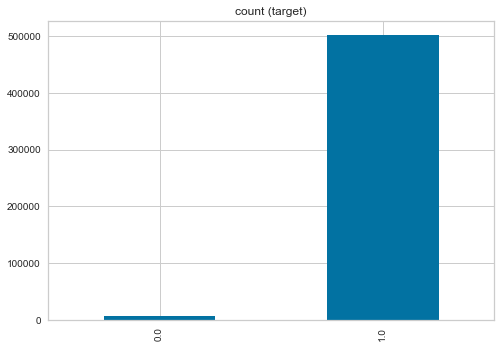

In [9]:
df2['CASE_STATUS'].value_counts().plot(kind='bar', title='count (target)')

In [10]:
df2=df2.sort_values(by=['CASE_STATUS'])
df2=df2.iloc[:, :]
df2=df2.iloc[:33476, :]
df2 = df2.sample(frac = 1) 

In [11]:
VisaStatus_df = df2.groupby(['CASE_STATUS']).size().reset_index(name='counts')
print(VisaStatus_df)

   CASE_STATUS  counts
0          0.0    6676
1          1.0   26800


<AxesSubplot:title={'center':'count (target)'}>

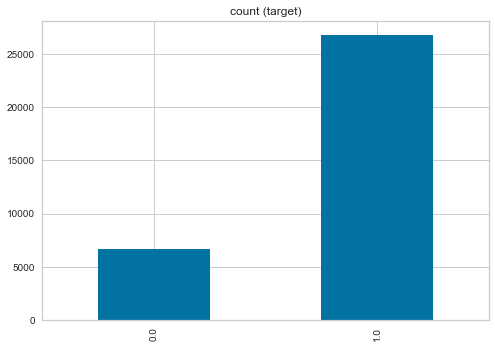

In [12]:
df2['CASE_STATUS'].value_counts().plot(kind='bar', title='count (target)')

# Data Preparation Part 2
Final dataset<br>
The final data set includes 34 columns and 37420 rows there are 25 rows that were made binary with one hot encoding 18 rows were created from the SOC_GROUP variable. All the one hot encoded variables were assigned a type of uint8 which are numbers between 0 to 255, the other variables were assigned to int64 except the variables for pay in dollar currency which were 4 variables that were assigned to float 64. There are 9 continuous variables and 26 binary variables. The target feature has 6,676 Denied values while the Certified had 26,800 values. The data is scaled to unit variance. The only New variables formed were DAYS_PROCESS, ANNUALIZED_PREVAILING_WAGE,
ANNUALIZED_WAGE_RATE_OF_PAY and the Dummy variables formed form the OneHotEncoder for SOC_GROUP. 

# Modeling and Evaluation 1

Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.


### Task 1 - Classification

When choosing an evaluation metric it is very important that we understand the business challenge we are trying to solve, this will allow us to see what parameters will create a more severe outcome and what measure can reveal that. The metrics being considered will be accuracy and recall. 

In this model it is very important to have the required employees with the skills required to complete a project that a company is undertaking, in time to complete the project. These induviduals are sought for because those skills were not readily avaiable in the job market in the united states and without these employees the company may not complete the job in time or in budget, this will cause loss of future projects and profit for the company. So when applying for these candidates it is very imporatnt that the company has a high likelihood that the employees will be certified.

With this information we see will use __accuracy__ metric to see how many True Positives and True negatives were correct out of the total number of predictions. It tells us generally overall how well the model predicted, however it does not consider the costs of having a mis-classified actual positive (or false negatives). 
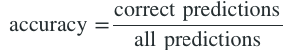

To make sure that the missclassifications are considered we use the recall metric and we are specifically looking at the __recall__ for the Denied category as this is the class that will cause severe setbacks. This is very important to us because our target is classify the candidates that were certified in time for the project duration, It would be very detrimental to the company if the model predicted that the candidate would be Certified while they are actually they would be Denied, this is a measure of __False Negatives__ from the Denied category. False negatives are taken into consideration with recall. Recall is defined as the fraction of examples which were predicted to belong to a class with respect to all of the examples that truly belong in the class.

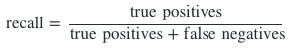
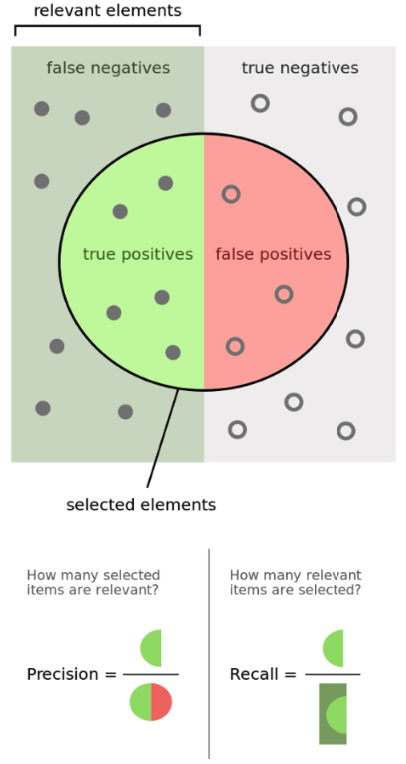

https://www.jeremyjordan.me/evaluating-a-machine-learning-model/

### Task 2 - Regression

MAE, MAPE and RMSE will be used to evaluate the processing days prediction error rates and model performance of the regression models.  MAE and RMSE are the two most popular metrics for continuous variables. These are appropriate measurements as the goal is an accurate prediction model.

While all three will be used for evalation, MAE will be the ultimate metric used to compare the models.  MAE is robust to outliers, as minimizing the absolute error results in finding the median; whereas RMSE is not as it minimizes the squared error, resulting in finding the mean. Also, MAE is a better choice for interpretation.

MAE (Mean Absolute Error) represents the difference between the original and predicted values extracted by averaging the absolute difference over the data set.

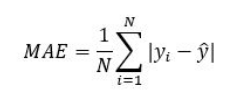

MAPE (Mean Absolute Percentage Error) measures the Mean Absolute error as a percentage, and can be calculated as the average absolute percent error for each time period minus actual values divided by actual values.

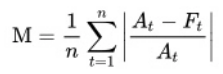

RMSE (Root Mean Squared Error) is the error rate by the square root of MSE. It represents the sample standard deviation of the differences between predicted values and observed values, otherwise known as residuals.

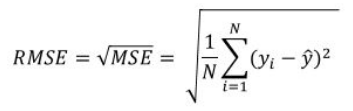

https://www.datatechnotes.com/2019/02/regression-model-accuracy-mae-mse-rmse.html#:~:text=MAE%20(Mean%20absolute%20error)%20represents,difference%20over%20the%20data%20set.

https://www.statisticshowto.com/mean-absolute-percentage-error-mape/#:~:text=It%20measures%20this%20accuracy%20as,values%20divided%20by%20actual%20values.


# Modeling and Evaluation 2

Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
 

### Task 1 - Classification

### 10-fold Stratified Cross Validation 
Cross-validation is a resampling procedure used to evaluate machine learning models and can be useful for limited data sizes.
The procedure has a parameter called k that refers to the number of groups that a given data set is to be split into. hence is called k-fold cross-validation. in this model we will be splitting the data into 10. This method picked because it reduced bias, the variance is reduced as k increases so as we have 10 folds the variance should be adequatley reduced. 

Stratified Shuffle Split Method<br>
This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class. This is important to us because our data set is imbalancd and inorder to keep the integrity of the data by not resampling which may lead to mis-leading high performing model.

In [13]:
# divide data set to x and y and Scale data
scl = StandardScaler()

yy = df2['CASE_STATUS']
xx = df2.drop(['CASE_STATUS'], axis=1)
xx = scl.fit_transform(xx)

In [15]:
a = df2['CASE_STATUS'].values
b = df2.drop(['CASE_STATUS'], axis=1)
b = b.values
b = scl.fit_transform(b)

print(xx.shape)
print(yy.shape)

(33476, 34)
(33476,)


In [16]:
# create train set
import random
random.seed(0)
xx_train,xx_test,yy_train,yy_test = train_test_split(xx,yy,test_size=0.2, random_state=0)
print(yy_train.shape)
print(xx_test.shape)

(26780,)
(6696, 34)


In [17]:
# cross validation
random.seed(10)
num_cv_iterations = 5
cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.3)

### Task 2 - Regression

The method used for dividing the dataset for regression modeling is ten-fold cross validation with repeated holdout using ShuffleSplit. 80% of the data set is used for training and 20% reserved for testing. This is the most common method based on the Pareto Principle and appropriate for the size of our data set.  Having more samples for training lowers the variance and this split allows us to achieve low variance over the model parameters. Alternatively, 20% reserved for testing ensures enough data to observe low variance among the performance results.  Ideally, the goal is to achieve low variance for both.

Using CV eliminates the need for a validation set, which drastically reduces the number of samples which can be used for training the model and the results can depend on a particular random choce for the pair of train & validation sets.  While this approach can be computationally expensive, it does not waste too much of the data. To ensure the same splits for each cross validation, a random seed was set.

Grid Searching for each model will be employed to calculate the best parameters to use for each regression model. Grid searching is computationally expensive and builds a model on each parameter combination possible. It iterates through every parameter combination and stores a model for each combination. 

https://scikit-learn.org/stable/modules/cross_validation.html
http://www.beyondthelines.net/machine-learning/how-to-split-a-dataset/


# Modeling and Evaluation 3

Here we first look at the classification model the code the move on the regression model and code.

### Task 1 - Classification

#### Classification models 

Models include
1. Random Forest Classifier
2. AdaBoost Classifier 

#### AdaBoost Investigated Parameters:
AdaBoost parameters that were tried were SAMME AND SAMME.R. Discrete SAMME AdaBoost adapts based on errors in predicted class labels whereas real SAMME.R uses the predicted class probabilities. The base_estimator must support calculation of class probabilities if the SAMME.R is to be used. In this case we use the default algorithm setting which is decision trees and this supports probabilities. 

After trial and errot it was determined that the SAMME.R produced the best overall results and in regards to our main metric of recall. SAMME.R also outperformed SAMME when considering the Denied category of the recall metric.Also three different learning rates were checked 1.0, 0.8 and 0.5 with grid search and we saw that 1.0 learning rate was the best. Learning rate shrinks the contribution of each classifier by the learning rate.

####  Random forest Investigated Parameters:
Random forest parameter search was criterion this function to measure the quality of a split. criterias include are gini for the Gini impurity and entropy for the information gain. from grid search we see that the best parameter is the Gini impurity. Which is how well the dataset can seperate the target data and pick correct values. While the entropy deals with the measure of uncertainty. 

### 1. Random forest Classifier

In [18]:
#CLASSIFICATION MODELS
# Classification Models Parameter search
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [19]:
# grid search
params = {
    'class_weight':['balanced'],        # 
    'criterion':['entropy','gini']
}

lr = RandomForestClassifier()
lr_gs = GridSearchCV(lr, params, cv=5, verbose=1).fit(xx_train, yy_train)

print_results(lr_gs)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
BEST PARAMS: {'class_weight': 'balanced', 'criterion': 'entropy'}

0.901 (+/-0.006) for {'class_weight': 'balanced', 'criterion': 'entropy'}
0.901 (+/-0.007) for {'class_weight': 'balanced', 'criterion': 'gini'}


In [20]:
pipe = Pipeline([('RDF',RandomForestClassifier(class_weight="balanced",criterion = 'entropy', random_state = 42))])

In [21]:
pd.set_option('display.max_rows', None)
from sklearn import metrics as mt
iter_num=0
average_accuracy = []
average_precision = []
average_recall = []
average_f1_score=[]
average_matrix=[]

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(b,a)):
    pipe.fit(b[train_indices],a[train_indices])  # train object
    y_hat = pipe.predict(b[test_indices])
    average_accuracy.append(mt.accuracy_score(a[test_indices],y_hat))
    average_precision.append(mt.precision_score(a[test_indices],y_hat))
    average_recall.append(mt.recall_score(a[test_indices],y_hat))
    average_f1_score.append(mt.f1_score(a[test_indices],y_hat)) 
    average_matrix.append(mt.confusion_matrix(a[test_indices],y_hat))
    
#    print("====Iteration",iter_num," ====")
#    print("accuracy", mt.accuracy_score(a[test_indices],y_hat))
#    print("precision", mt.precision_score(a[test_indices],y_hat)) 
#    print("recall", mt.recall_score(a[test_indices],y_hat)) 
#    print("f1-score", mt.f1_score(a[test_indices],y_hat))
#    print("confusion matrix\n",mt.confusion_matrix(a[test_indices],y_hat))
#    print(classification_report(a[test_indices],y_hat))

In [22]:
# Averaged results of 10fold Stratified Cross Validation Random Forest

final_accuracy = sum(average_accuracy)/len(average_accuracy)
final_precision = sum(average_precision)/len(average_precision)
final_recall = sum(average_recall)/len(average_recall)
final_f1_score = sum(average_f1_score)/len(average_accuracy)
final_confusion_mat = sum(average_matrix)/len(average_matrix)

print("logistic regression averaged results")
print("average accuracy",final_accuracy)
print("average precision",final_precision)
print("average recall",final_recall)
print("average f1_score",final_f1_score)
print("confusion matrix\n",final_confusion_mat)

logistic regression averaged results
average accuracy 0.9024195957383251
average precision 0.9142644757286164
average recall 0.9689800995024876
average f1_score 0.9408261486825366
confusion matrix
 [[1272.4  730.6]
 [ 249.4 7790.6]]


### 2. AdaBoost Classifier

In [23]:
# parameter grid search
params = {
    'algorithm':['SAMME.R', 'SAMME'],        # 
    'learning_rate':[1, 0.8, 0.5]
}

lr = AdaBoostClassifier()
lr_gs = GridSearchCV(lr, params, cv=5, verbose=1).fit(xx_train, yy_train)

print_results(lr_gs)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
BEST PARAMS: {'algorithm': 'SAMME.R', 'learning_rate': 1}

0.906 (+/-0.005) for {'algorithm': 'SAMME.R', 'learning_rate': 1}
0.906 (+/-0.005) for {'algorithm': 'SAMME.R', 'learning_rate': 0.8}
0.904 (+/-0.007) for {'algorithm': 'SAMME.R', 'learning_rate': 0.5}
0.897 (+/-0.007) for {'algorithm': 'SAMME', 'learning_rate': 1}
0.889 (+/-0.007) for {'algorithm': 'SAMME', 'learning_rate': 0.8}
0.889 (+/-0.007) for {'algorithm': 'SAMME', 'learning_rate': 0.5}


In [24]:
pipe = Pipeline([('ADB',AdaBoostClassifier(learning_rate=1.0,algorithm = 'SAMME.R' ))])
pipe.fit(b[train_indices],a[train_indices])
y_hat = pipe.predict(b[test_indices])

In [25]:
pd.set_option('display.max_rows', None)
from sklearn import metrics as mt
iter_num=0
average_accuracy = []
average_precision = []
average_recall = []
average_f1_score=[]
average_matrix=[]

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(b,a)):
    pipe.fit(b[train_indices],a[train_indices])  # train object
    y_hat = pipe.predict(b[test_indices])
    average_accuracy.append(mt.accuracy_score(a[test_indices],y_hat))
    average_precision.append(mt.precision_score(a[test_indices],y_hat))
    average_recall.append(mt.recall_score(a[test_indices],y_hat))
    average_f1_score.append(mt.f1_score(a[test_indices],y_hat)) 
    average_matrix.append(mt.confusion_matrix(a[test_indices],y_hat))
    
#    print("====Iteration",iter_num," ====")
#    print("accuracy", mt.accuracy_score(a[test_indices],y_hat))
#    print("precision", mt.precision_score(a[test_indices],y_hat)) 
#    print("recall", mt.recall_score(a[test_indices],y_hat)) 
#    print("f1-score", mt.f1_score(a[test_indices],y_hat))
#    print("confusion matrix\n",mt.confusion_matrix(a[test_indices],y_hat))
#    print(classification_report(a[test_indices],y_hat))

In [26]:
# Averaged results of 10fold Stratified Cross Validation ADABoost

final_accuracy = sum(average_accuracy)/len(average_accuracy)
final_precision = sum(average_precision)/len(average_precision)
final_recall = sum(average_recall)/len(average_recall)
final_f1_score = sum(average_f1_score)/len(average_accuracy)
final_confusion_mat = sum(average_matrix)/len(average_matrix)

print("logistic regression averaged results")
print("average accuracy",final_accuracy)
print("average precision",final_precision)
print("average recall",final_recall)
print("average f1_score",final_f1_score)
print("confusion matrix\n",final_confusion_mat)

logistic regression averaged results
average accuracy 0.9065816986956088
average precision 0.9055728008740334
average recall 0.9861442786069652
average f1_score 0.9441398360365794
confusion matrix
 [[1176.2  826.8]
 [ 111.4 7928.6]]


### Task 2 - Regression

code for this section adapted from:

https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

The following regression models will be used to compare against the base linear regression model for the task of predicting the processing days for the LCA.  Each model will be compared using average MAE, MAPE and RSME results based on 10 Cross Validation folds of the optimized model parameters as indicated from the results of the grid search.  Ultimately, MAE and  a statistical comparison will be the deciding factor to determine the best model moving forward.

<b>LASSO</b>
Selected to develop a simple, sparse model to address any high level of multi collinearity that may be present in the data.  LASSO uses L1 regularization, adding a penalty equal to the magnitude of coefficients, which may take some coefficients to zero, thereby eliminating them from the model.

<b>Ridge Regression</b>
Selected to decrease model complexity by penalizing coefficients if they are too far from zero  (L2 penalty); forcing them to be small in a continuous way and keeping all variables in the model.

<b>Elasticnet</b>
Selected as it combines the penalties of ridge regression and LASSO to get the best of both models and we can compare the results of all three to see which is best for our data. 

<b>Multi-Layer Perceptron</b>
Selected as a curiousity to see how a neural network compares to more traditional regression models.


<b>Random Forest</b>
Selected as it works well on large datasets and often produce better results vs linear regresion as each tree is created from a different sample of rows and at each node a sample of features is selected for splitting. Each tree's predictions are then averaged to produce a single result. 



https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

In [4]:
df8 = pd.read_csv ('Clean_Visa_Regression.csv')

In [7]:
df8.describe()

,DAYS_PROCESS,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,ANNUALIZED_PREVAILING_WAGE,ANNUALIZED_WAGE_RATE_OF_PAY,WILL_VIOL_Y,"Arts, Design, Entertainment, Sports, and Media",...,Office and Administrative Support,Personal Care and Service,Production,Protective Services,Sales and Related,Transportation and Material Moving,AGENT_REP_Y,H1B_DEP_Y,LABOR_CON_AGREE_Y,SUPPORT_H1B_Y
count,33476.000000,33476.000000,33476.000000,33476.000000,33476.000000,33476.000000,33476.000000,33476.000000,33476.000000,33476.000000,...,33476.000000,33476.000000,33476.000000,33476.0,33476.000000,33476.000000,33476.000000,33476.000000,33476.000000,33476.000000
mean,5.356225,2.112230,0.882154,0.345830,0.169644,0.008992,74416.168365,87158.937628,0.000807,0.015623,...,0.001374,0.000777,0.000807,0.0,0.005168,0.000090,0.552545,0.368025,0.406889,0.367278
std,1.409909,5.786439,4.136484,1.450022,1.464151,0.305796,22681.039825,29476.030196,0.028389,0.124014,...,0.037044,0.027858,0.028389,0.0,0.071703,0.009466,0.497239,0.482275,0.491261,0.482070
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12000.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,58552.000000,65000.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,70616.000000,80002.090000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,87859.000000,104000.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,10.000000,155.000000,150.000000,55.000000,50.000000,50.000000,148370.000000,181000.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<b> Setting up the data and helper functions</b>

In [8]:
# divide data set to x explanatory and y response variable
X = df8.drop(columns=['DAYS_PROCESS'])
y = df8['DAYS_PROCESS']

In [9]:
#CROSS VALIDATION 
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=24)

In [10]:
#CREATE METRICS
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               }

In [11]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

### BASELINE LINEAR REGRESSION MODEL

In [86]:
from sklearn.linear_model import LinearRegression
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = LinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=24, test_size=0.2, train_size=None),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': (True, False),
                         'normalize': (True, False)},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [87]:
#Print the parameterization of the best estimator
regGridSearch.best_estimator_

LinearRegression(normalize=True)

In [88]:
LRregEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(LRregEstimator, X, y, cv)

The average MAE for all cv folds is: 			 1.0768
The average MAE percentage (MAPE) for all cv folds is: 	 33.909
The average RMSE for all cv folds is: 			 1.3787
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,1.087315,34.861079,1.393722
1,1.088324,34.867341,1.402731
2,1.074347,33.362901,1.371090
3,1.067730,32.825063,1.359723
4,1.078060,33.630872,1.374514
5,1.068672,33.761874,1.369620
6,1.071291,33.860369,1.373094
7,1.074652,33.917896,1.377963
8,1.081981,34.219051,1.387476
9,1.075668,33.784028,1.377281


### LASSO

In [89]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   22.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   25.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=24, test_size=0.2, train_size=None),
             estimator=Lasso(max_iter=10000, normalize=True, precompute=True,
                             random_state=0),
             n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [90]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Lasso(alpha=0.001, max_iter=10000, normalize=True, precompute=True,
      random_state=0, warm_start=True)

In [91]:
from sklearn.linear_model import Lasso

#Create a regression estimator with best parameters for cross validation
LSregEstimator = Lasso(alpha=0.001, max_iter=10000,
                     normalize=True, precompute=True, random_state=0,
                     warm_start=True)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(LSregEstimator, X, y, cv)

The average MAE for all cv folds is: 			 1.1152
The average MAE percentage (MAPE) for all cv folds is: 	 35.293
The average RMSE for all cv folds is: 			 1.4044
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,1.125248,36.342036,1.422071
1,1.126324,36.181979,1.427158
2,1.117223,34.824996,1.401159
3,1.104789,34.159696,1.383403
4,1.114567,34.961879,1.397471
5,1.108965,35.257976,1.399831
6,1.105454,35.160157,1.395323
7,1.113209,35.262073,1.401893
8,1.119154,35.555091,1.411026
9,1.117168,35.227278,1.404733


### RIDGE REGRESSION

In [92]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

reg = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   18.3s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:   24.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=24, test_size=0.2, train_size=None),
             estimator=Ridge(max_iter=1000, normalize=True, random_state=0,
                             tol=0.0001),
             n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20],
                         'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg',
                                    'sag', 'saga']},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [93]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Ridge(alpha=0.001, max_iter=1000, normalize=True, random_state=0,
      solver='sparse_cg', tol=0.0001)

In [94]:
#Create a regression estimator with best parameters for cross validation
RGregEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(RGregEstimator, X, y, cv)

The average MAE for all cv folds is: 			 1.0768
The average MAE percentage (MAPE) for all cv folds is: 	 33.911
The average RMSE for all cv folds is: 			 1.3787
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,1.087355,34.863011,1.393727
1,1.088359,34.868910,1.402719
2,1.074393,33.364824,1.371103
3,1.067766,32.826904,1.359716
4,1.078103,33.632327,1.374497
5,1.068711,33.763293,1.369612
6,1.071331,33.862106,1.373086
7,1.074697,33.919559,1.377958
8,1.082014,34.220590,1.387458
9,1.075708,33.785794,1.377279


### ELASTICNET

In [95]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

reg = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:   12.4s
[Parallel(n_jobs=8)]: Done 960 out of 960 | elapsed:   13.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=24, test_size=0.2, train_size=None),
             estimator=ElasticNet(max_iter=10000, normalize=True,
                                  precompute=True, random_state=0),
             n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10],
                         'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [96]:
#Display the best estimator parameters
regGridSearch.best_estimator_

ElasticNet(alpha=0.001, l1_ratio=0.001, max_iter=10000, normalize=True,
           precompute=True, random_state=0, selection='random',
           warm_start=True)

In [97]:
#Create a regression estimator with best parameters for cross validation
EregEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(EregEstimator, X, y, cv)

The average MAE for all cv folds is: 			 1.1129
The average MAE percentage (MAPE) for all cv folds is: 	 35.219
The average RMSE for all cv folds is: 			 1.4018
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,1.123041,36.263725,1.419455
1,1.124020,36.111187,1.424643
2,1.114704,34.747244,1.398445
3,1.102464,34.086133,1.380795
4,1.112391,34.889583,1.394929
5,1.106614,35.174918,1.396902
6,1.103410,35.089142,1.392899
7,1.110933,35.189085,1.399393
8,1.116967,35.483218,1.408560
9,1.114737,35.151125,1.402058


### MULTI-LAYER PERCEPTRON

In [98]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.neural_network import MLPRegressor

linreg = MLPRegressor()
parameters = { 'activation':['logistic']
              ,'hidden_layer_sizes' : [200]
              ,'solver': ['sgd','adam']
              ,'alpha': [0.001]
              ,'batch_size':['auto'] 
              ,'random_state': [0]
              ,'learning_rate': ['constant', 'invscaling', 'adaptive']
              ,'learning_rate_init':[0.001]
              ,'power_t':[0.5]
              ,'max_iter':[1000]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:  3.5min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=24, test_size=0.2, train_size=None),
             estimator=MLPRegressor(), n_jobs=8,
             param_grid={'activation': ['logistic'], 'alpha': [0.001],
                         'batch_size': ['auto'], 'hidden_layer_sizes': [200],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'learning_rate_init': [0.001], 'max_iter': [1000],
                         'power_t': [0.5], 'random_state': [0],
                         'solver': ['sgd', 'adam']},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [99]:
#Display the best estimator parameters
regGridSearch.best_estimator_

MLPRegressor(activation='logistic', alpha=0.001, hidden_layer_sizes=200,
             max_iter=1000, random_state=0)

In [100]:
#CreateLinearRegression predictions using the best parameters for our Linear Regression object
MPregEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(MPregEstimator, X, y, cv)

The average MAE for all cv folds is: 			 1.1088
The average MAE percentage (MAPE) for all cv folds is: 	 35.219
The average RMSE for all cv folds is: 			 1.4038
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,1.110566,36.263358,1.421637
1,1.155705,36.131786,1.427113
2,1.092491,34.708750,1.398674
3,1.087201,34.099303,1.383594
4,1.116664,34.902519,1.395831
5,1.107518,35.186443,1.398151
6,1.124482,35.120281,1.395255
7,1.113699,35.174193,1.400675
8,1.083253,35.477644,1.412645
9,1.096526,35.127034,1.404395


### RANDOM FOREST

##### DO NOT RUN - - Processing time is lengthy

In [27]:
#RANDOM FOREST 
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.ensemble import RandomForestRegressor

linreg = RandomForestRegressor()
parameters = {'max_depth' :[30]
              ,'n_estimators' : [75]
              ,'min_samples_leaf': [10, 25, 50]
              ,'criterion': ['mae']
              ,'n_jobs':[8] 
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
RFregGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
RFregGridSearch.fit(X, y)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed: 473.3min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=24, test_size=0.2, train_size=None),
             estimator=RandomForestRegressor(), n_jobs=8,
             param_grid={'criterion': ['mae'], 'max_depth': [30],
                         'min_samples_leaf': [10, 25, 50], 'n_estimators': [75],
                         'n_jobs': [8], 'random_state': [0]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [28]:
#RANDOM FOREST
#Display the best estimator parameters
RFregGridSearch.best_estimator_

RandomForestRegressor(criterion='mae', max_depth=30, min_samples_leaf=50,
                      n_estimators=75, n_jobs=8, random_state=0)

In [29]:
#RANDOM FOREST
#Create a regression estimator with best parameters for cross validation
RFregEstimator = RFregGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(RFregEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.87782
The average MAE percentage (MAPE) for all cv folds is: 	 33.946
The average RMSE for all cv folds is: 			 1.4833
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,0.896159,35.118681,1.504645
1,0.900270,35.198628,1.519029
2,0.881481,33.534550,1.479143
3,0.861226,32.592591,1.455525
4,0.869283,33.413760,1.467107
5,0.867890,33.781492,1.475739
6,0.871523,33.843891,1.474910
7,0.879344,34.035255,1.489888
8,0.876719,34.141393,1.484103
9,0.874256,33.796835,1.482922


## Modeling and Evaluation 4

Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

### Task 1 - Classification

The classification models will be used to predict the certified or denied values of applicants. There were three classification models that are beings accessed in this study. The metrics of importance will be the recall and accuracy. 

Heatmap<br>
There are severe consequnces that results if candidates that are predicited certified when they are denied hence False Negatives (recall) of the Denied category will be the deciding factor. The false negatives of the Denied category tells us how many of the total number of actual denied were predicted correctly as denied. Generally the model did not perform too well in all the classifiers the Denied recall for the Random Forest and ADAboost were 0.65 and 0.61 percent respectivly we can see that the Random Forest classifier best predicted the actually Denied candidates. 

And for the precision of the Certified class the results were very similar for both classifiers, from 0.90 to 0.91 while the precision for the Denied class varied significantly with random forest and ADAboosthaving respectively a score of 0.85 and 0.91. In this metric the ADAboost seems to be the most adequate model that can determine how precise your model is out of those predicted positive, how many of them are actually positive.
  

ROC Curve<br>
When the ROC curve is on the black dashed line it means the True Positive rate is eqaul to the False Positive. But When AUC is above .5 (the black dashed line), then the classifier will be able to distinguish the positive class values from the negative class values. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives, or we can say the proportion of correctly classified points belonging to the Positive class is greater than the proportion of incorrectly classified points belonging to the Negative class.  

In both of the Curve diagrams there is a pattern that is formed we see that the rate of increase of the Denied class is higher than that of Certified and they both cross at point. Ultimately although they both have different shapes they have the same area under curve (AUC). The main take away from the faster increase of the denied category is that it has a higher number of True Negatives than False Positives compared to the certified class. This is tells us that it has a higher number of correct predictions for the Certified class than False predictions for the Denied class.
Overall results were the random forest AUC for both denied and certified was 0.90, ADAboost AUC for both denied and certified was 0.90. The results were pretty close and may not be significant difference in the differentiating between the positive and negative class for both models. 


Bar Chart<br>
The bar chart is a general visualisation of the full model accounting for both classes combined (denied and certified) for the recall and accuracy metric. We see that for total recall of model the ADAboost has the highest value and is higher with about 0.018 than the random forest. For total accuracy we see that ADAboost is slightly better by 0.004 and this a miniscule value and may not be significant. 

In conclusion judging by overall metric of recall and accuracy the ADAboost model is performing better at both metrics for the predictions however our main goal is correct prediction of the denied category which the random forest is better at predicting if we look at induvidual category performances from the heat map charts.

### Random forest Heat map Results

In [27]:
# Create pipeline
pipe = Pipeline([('RDF',RandomForestClassifier(class_weight="balanced",criterion='entropy',random_state = 42))])
pipe.fit(b[train_indices],a[train_indices])
y_hat = pipe.predict(b[test_indices])

Text(0.5, 1.0, 'Heatmap of Random forest Classifer ')

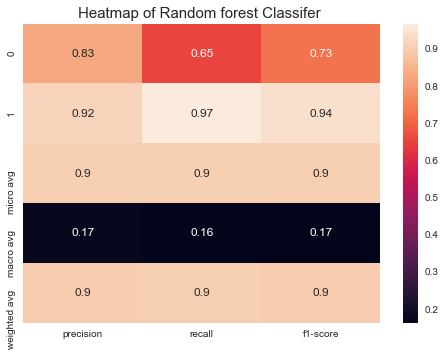

In [28]:
labels = np.arange(10)
target_names=[0,1]
clf_report = classification_report(a[test_indices],y_hat,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title('Heatmap of Random forest Classifer ', fontsize = 15)

### Random Forest ROC Curve Results

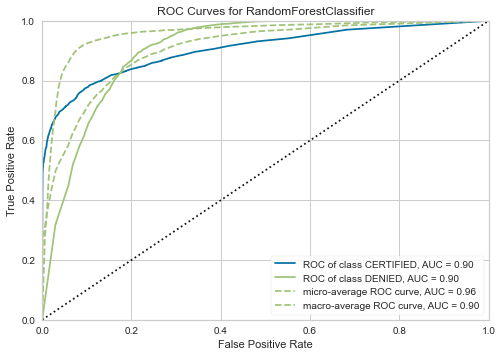

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [29]:
from yellowbrick.classifier import ROCAUC,ClassPredictionError
model = RandomForestClassifier(class_weight="balanced",criterion = 'gini', random_state = 42)
visualizer = ROCAUC(model, classes=["CERTIFIED", "DENIED"])

visualizer.fit(xx_train,yy_train)        
visualizer.score(xx_test,yy_test)        
visualizer.show()

### ADABoost Classifier HeatMap

In [30]:
pipe = Pipeline([('ADB',AdaBoostClassifier(learning_rate=1.0,algorithm = 'SAMME.R',random_state = 42))])
pipe.fit(b[train_indices],a[train_indices])
y_hat = pipe.predict(b[test_indices])

Text(0.5, 1.0, 'Heatmap of ADABoost Classifier')

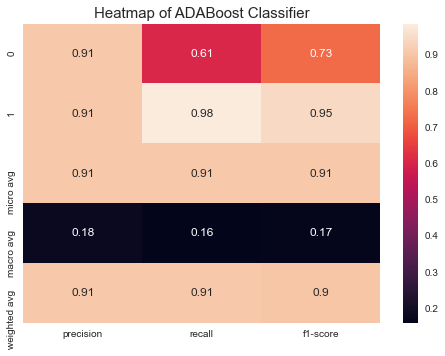

In [31]:
labels = np.arange(10)
target_names=[0,1]
clf_report = classification_report(a[test_indices],y_hat,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title('Heatmap of ADABoost Classifier', fontsize = 15)


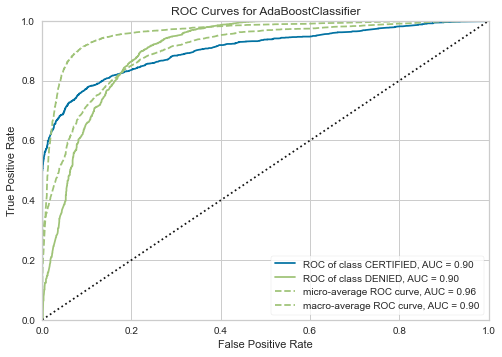

<AxesSubplot:title={'center':'ROC Curves for AdaBoostClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [32]:
mod = AdaBoostClassifier(learning_rate=1.0,algorithm = 'SAMME.R', random_state = 42)
visualizer = ROCAUC(mod, classes=["CERTIFIED", "DENIED"])

visualizer.fit(xx_train,yy_train)        
visualizer.score(xx_test,yy_test)        
visualizer.show()

In [33]:
models = []
#models.append(('BG',knn()))
models.append(('RDF',RandomForestClassifier(random_state=42, class_weight="balanced",criterion='gini')))
models.append(('ADB',AdaBoostClassifier(learning_rate=1.0,algorithm = 'SAMME.R',random_state = 42)))

In [34]:
results = []
names = []
scoring = 'recall'
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, b, a, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RDF: 0.968736 (0.002529)
ADB: 0.986650 (0.002484)


### Recall Comparison Visualization

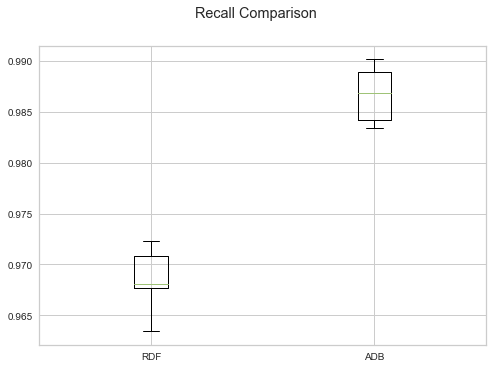

In [35]:
fig = plt.figure()
fig.suptitle('Recall Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [36]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, b, a, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RDF: 0.904349 (0.005455)
ADB: 0.907486 (0.005701)


### Accuracy Comparison Visualization

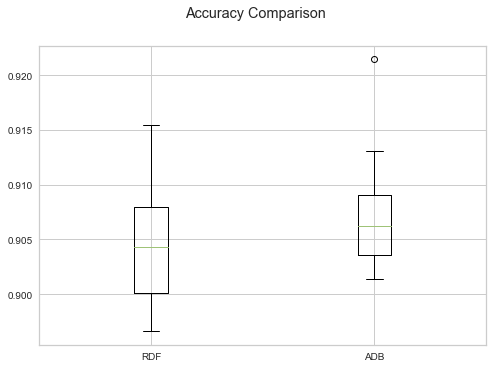

In [37]:
fig = plt.figure()
fig.suptitle('Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Task 2 - Regression

##### Metric Comparison across Models

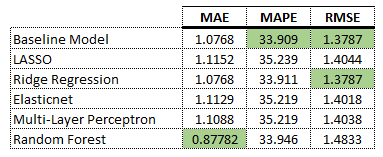

The base linear regression model resulted in an MAE of 1.0768 (33.909%) and an RSME of 1.3787.

Our first comparison is between LASSO, Ridge and Elasticnet.  Ridge performed much better than LASSO, indicating that the L2 penalty and keeping all coefficients in the model was the better choice.  Because Elasticnet combines the best of both models, it did not perform as well as Ridge because of the influece of the LASSO Model.  When comparing the Ridge model vs. the baseline regression model, it performed nearly identically, with the exception of MAPE which was slightly higher (33.911 vs. 33.909).

Mutli-Layer Perceptron performed slightly worse than the baseline, but produced better results than LASSO or Elasticnet from a MAE perspective.

Random Forest performed much better on MAE (0.87782), nearly the same for MAE Percentage and worse on RMSE vs the baseline model.

The visual provides overall performance for each of the models on all of the measurement metrics, in one summary chart (which alleviates the need to scroll through the code to find the results).  The user can then make an informed decision as to the better model based on the criteria of their choosing.  While we selected MAE for this analysis, in which case Random Forest performed the best; if the choosen metric was RSME this would lead to either using a Linear or Ridge regression model.

<AxesSubplot:title={'center':'MAE Across CV Folds by Model'}>

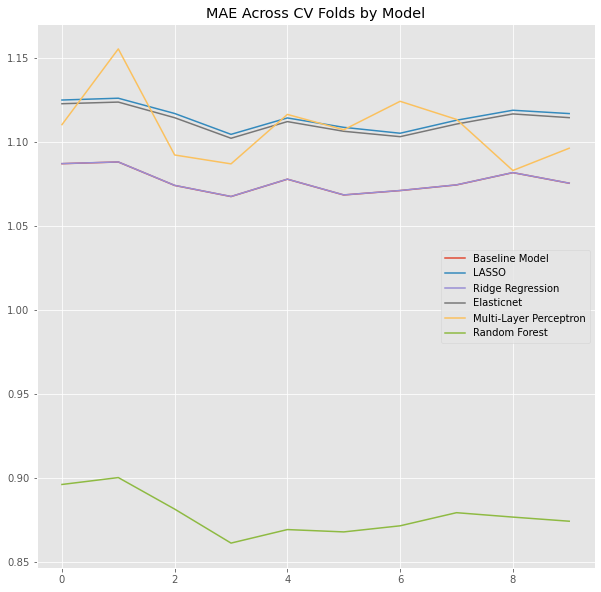

In [85]:
mae = pd.read_csv ('Model_MAE_Scores.csv')
mae.plot(kind = 'line', figsize=(10,10), title='MAE Across CV Folds by Model')

In the chart above, all six models are shown along with their respective MAE scores across each CV fold. This visual clearly shows that Random Forest performed significantly better across all ten folds vs. the other models, ranging between .87 and .90.  Ridge and the Baseline Regression Model had the next best performance (note that Ridge and the Baseline Model have overlapping lines).  LASSO and Elasticnet had identical patterns throughout the folds, with poorer perfomance vs. the other models.  Multi-Layer Perceptron's performance depended on the fold and lacked consistency in performance, which could be problematic during deployment.  

This provides insight into the MAE performance across each fold for the various models.  It is useful as it provides information "at-a-glance"  For example, the line for Multi-Layer Perceptron makes the variance between folds quite clear, which wasn't as easily evident when simply looking at the numerical results.  Having the results in one place also increases efficiency in the decision making process. 

## Modeling and Evaluation 5

### Task 1 - Classification

Random forest<br>
1. Better Recall for the critical category - Denied
2. Better F1 score for the critical category - Denied 


AdaBoost Classifier<br>
1. Better for determing over all Recall for both categories.
2. Better to determine the precision of the Denied category.

In the Overall results recall ADAboost seems to be the better model for recall from the bar charts and the paired t test. The paired t-test suggests that there is significant difference betweens the two models. using mlxtend.evaluate and ensuring that the p-value was less than 0.05, assuming the null hypothesis is that there is no significant difference between the two models. I can say with 95% confidence that the overall recall metric may be better in ADAboost than Random Forest. 

While for accuracy the two models seem to be similar. We can see this with the AUC curve both having the same approximate value of 0.89. Also The results of the paired t-test suggests that with 95% confidence we fail to reject the null hypothesis of the models being the same. In other words the accuracy of the two models may not have signifiicant diffrence in values. 

Best Model<br>
The best model is the Random Forest model because the consequences of having False Negatives particularly in the Denied category is very high vs the tradeoff of advantages of False positives is very low. The false positives of the Denied class would be when If the company is informed that the employee is denied while he/she is Certified there will be little to no negative effect on projects since the company will be well prepared and find alternative measures. So Although ADAboost is a better model as a whole for prediction, it has a lower Denied recall of 0.58 while Random Forest has a Denied recall of 0.63 which is better since predictions for the severe category would be more accurate from this model.


In [38]:
RDF = RandomForestClassifier(class_weight="balanced",criterion = 'gini', random_state = 42)
ADB = AdaBoostClassifier(learning_rate=1.0,algorithm = 'SAMME.R',random_state = 42)

In [39]:
from mlxtend.evaluate import paired_ttest_5x2cv

In [40]:
t, p = paired_ttest_5x2cv(estimator1=ADB, estimator2=RDF, X=b, y=a, scoring='recall', random_seed=1)

In [41]:
if p <= 0.05:
	print('Difference between mean performance is probably real')
else:
	print('Algorithms probably have the same performance')

Difference between mean performance is probably real


In [42]:
t, p = paired_ttest_5x2cv(estimator1=RDF, estimator2=ADB, X=b, y=a, scoring='accuracy', random_seed=1)

In [43]:
if p <= 0.05:
	print('Difference between mean performance is probably real')
else:
	print('Algorithms probably have the same performance')

Difference between mean performance is probably real


### Task 2 - Regression

Advantages of Each Model

<b>Linear Regression</b>

1.	Simple method
2.	Good interpretation
3.	Easy to implement

<b>LASSO Regression</b>

1.	Select features, by shrinking co-efficient towards zero.
2.	Avoids over fitting

<b>Ridge Regression</b>

1.	Trades variance for bias 
2.	Prevents over fitting

<b>Elastic Net</b>

1.	Combines the best of the LASSO and Ridge models, which could result in a better model depending upon the complexities of the data.


<b>Multi-Layer Perceptron</b>

1.	Once trained, the predictions are pretty fast.
2.	Neural networks can be trained with any number of inputs and layers.
3.	Neural networks work best with more data points.

<b>Random Forest</b>

1.	One third of data is not used for training, which can be used for testing.
2.	High performance and accurate
3.	Provides feature importance estimate
4.	Can automatically handle missing values
5.	No feature scaling is required

https://medium.com/@gokul.elumalai05/pros-and-cons-of-common-machine-learning-algorithms-45e05423264f

#### Statistical Comparison of Regression Models

To identify which model is the better choice for our analysis, the decision will be based on MAE vs. RSME.

MAE is the average over the verification sample of the absolute values of the differences between forecast and the corresponding observation. The MAE is a linear score which means that all the individual differences are weighted equally in the average.  

The RMSE is a quadratic scoring rule which measures the average magnitude of the error and gives a relatively high weight to large errors. This means the RMSE is most useful when large errors are particularly undesirable. In the case of this analysis, the time span of DAYS_PROCESS in the data is 0-10 days, so we do not feel this is a concern.

With the baseline mode, the difference between MAE and RSME is 0.3019 and 0.6548 with Random Forest, indicating that Random Forest had greater variance in the individual errors in the sample.

http://www.eumetrain.org/data/4/451/english/msg/ver_cont_var/uos3/uos3_ko1.htm

Based on the MAE results shown in the table below, the better performing models appear to be the Baseline Linear Regression Model, Ridge Regression and Random Forest.  Of the three, we believe that Random Forest is the best performing model for our analysis. 

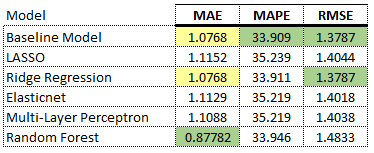

<b>To validate this hypothesis and determine if the difference is meaningful vs the other two models, we will compare the three models using the Paired T-Test with CV = 5.</b>

Based on the outcome of the statistical testing, we see that the Baseline Model and Ridge Regression Model did not have a meaningful difference, as expected based on the same MAE scores.  When comparing the Random Forest Model to the Baseline Model, we see that there is a stastistically meaningful difference. The Random Forest Model compared against the Ridge Regression Model also indicates a statistically meaningful difference.

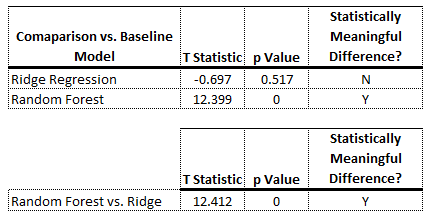

<b>This confirms that the best performing model for our analysis is Random Forest.</b> 


https://machinelearningmastery.com/hypothesis-test-for-comparing-machine-learning-algorithms/
http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/

In [101]:
from mlxtend.evaluate import paired_ttest_5x2cv

Baseline Regression Model vs. Ridge

In [109]:
# compare algorithms
t, p = paired_ttest_5x2cv(estimator1=LRregEstimator, estimator2=RGregEstimator, X=X, y=y, random_seed=28)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

# interpret the result
if p <= 0.05:
	print('Difference between mean performance is probably real')
else:
	print('Algorithms probably have the same performance')

t statistic: -0.697
p value: 0.517
Algorithms probably have the same performance


Baseline Regression Model vs. Random Forest

In [113]:
# compare algorithms
t, p = paired_ttest_5x2cv(estimator1=LRregEstimator, estimator2=RFregEstimator, X=X, y=y, random_seed=28)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

# interpret the result
if p <= 0.05:
	print('Difference between mean performance is probably real')
else:
	print('Algorithms probably have the same performance')

t statistic: 12.399
p value: 0.000
Difference between mean performance is probably real


Random Forest vs. Ridge Regression

In [114]:
# compare algorithms
t, p = paired_ttest_5x2cv(estimator1=RGregEstimator, estimator2=RFregEstimator, X=X, y=y, random_seed=28)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

# interpret the result
if p <= 0.05:
	print('Difference between mean performance is probably real')
else:
	print('Algorithms probably have the same performance')

t statistic: 12.412
p value: 0.000
Difference between mean performance is probably real


## Modeling and Evaluation 6

### Task 1 - Classification

From the tables below we can see that the top 2 most influential features are the DAYS_PROCESS and ANNUALIZED_WAGE_RATE_OF_PAY these seem to be important. Using SelectFromModel from scikit learn we able to select the impurity-based feature importances and the other less important features variable would be discarded. with this model we saw that it selected the top 3 features for the Random forest Classifier while for the AdaBoost the top 5 were selected. 

DAYS_PROCESS should be potentially very important since the decision for Denied or Certified may have have a time range pattern between those that were Certified and Denied that could be detected by our model and made it a good predictor. Also the ANNUALIZED_WAGE_RATE_OF_PAY could be important as there may be consistency with the jobs that they are not finding the skills in the united states may be highly technical and high salary jobs which may also cause better predictions. LABOR_CON_AGREE_Y is also important in the favored model this may mean that when these are considered it would help us tell find our if the will be Denied or not. AGENT_REP_Y is also important in the random forest model we are assuming that if a company does not have an agent it may negatively affect the certification and that is why it may be prominent in our preffered model of Random forest, which is better at predicting the actual denied candidates. Also the SOC_GROUP Computer and Mathematical had a very large number of candidates and seems to be very influential in determining the Certification prediction since this field is highly technical there may be a shortage of people with this skill set, and Denying these candidates may have severe outcome.

In [44]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

In [45]:
XX = df2.drop(['CASE_STATUS'], axis=1)
perm = PermutationImportance(RDF).fit(xx_train,yy_train)

In [47]:
#eli5.show_weights(perm, feature_names = XX.columns.tolist())

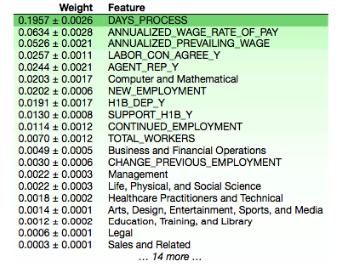

In [48]:
XX = df2.drop(['CASE_STATUS'], axis=1)
feat_labels = XX.columns
clf = RDF.fit(xx_train, yy_train)

In [49]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(xx_train)
X_new.shape

for feature_list_index in model.get_support(indices=True):
    print(feat_labels[feature_list_index])

ANNUALIZED_PREVAILING_WAGE
ANNUALIZED_WAGE_RATE_OF_PAY
DAYS_PROCESS


In [50]:
perm = PermutationImportance(ADB).fit(xx_train,yy_train)
#eli5.show_weights(perm, feature_names = XX.columns.tolist())

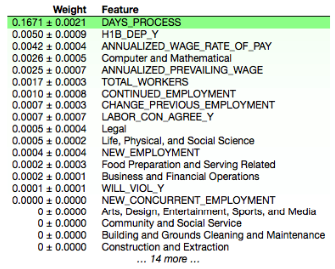

In [51]:
clf = ADB.fit(xx_train, yy_train)

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(xx_train)
X_new.shape

for feature_list_index in model.get_support(indices=True):
    print(feat_labels[feature_list_index])

TOTAL_WORKERS
NEW_EMPLOYMENT
ANNUALIZED_PREVAILING_WAGE
ANNUALIZED_WAGE_RATE_OF_PAY
DAYS_PROCESS
Computer and Mathematical
H1B_DEP_Y


### Task 2 - Regression

Top Performing Model - Random Forest 

DO NOT RUN - Processing time

Data will be scaled and grid search re-run and evaluated on the data.

In [115]:
#Scale dataset converting to standard normally distributed data 

from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_Scl = scaler.transform(X)

In [116]:
#RANDOM FOREST SCALED DATA
#Create Regression object and perform a grid search to find the best parameters
from sklearn.ensemble import RandomForestRegressor

linreg = RandomForestRegressor()
parameters = {'max_depth' :[30]
              ,'n_estimators' : [75]
              ,'min_samples_leaf': [10, 25, 50]
              ,'criterion': ['mae']
              ,'n_jobs':[8] 
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
RFSregGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
RFSregGridSearch.fit(X_Scl, y)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed: 469.2min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=24, test_size=0.2, train_size=None),
             estimator=RandomForestRegressor(), n_jobs=8,
             param_grid={'criterion': ['mae'], 'max_depth': [30],
                         'min_samples_leaf': [10, 25, 50], 'n_estimators': [75],
                         'n_jobs': [8], 'random_state': [0]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [117]:

#Display the best estimator parameters
RFSregGridSearch.best_estimator_

RandomForestRegressor(criterion='mae', max_depth=30, min_samples_leaf=50,
                      n_estimators=75, n_jobs=8, random_state=0)

In [118]:
#DO NOT RUN

#Create a regression estimator with best parameters for cross validation
RFSregEstimator = RFSregGridSearch.best_estimator_

EvaluateRegressionEstimator(RFSregEstimator, X_Scl, y, cv)
#Fit the model 
#RFSregEstimator.fit(X_Scl, y)

The average MAE for all cv folds is: 			 0.87781
The average MAE percentage (MAPE) for all cv folds is: 	 33.946
The average RMSE for all cv folds is: 			 1.4833
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,0.896159,35.118681,1.504645
1,0.900268,35.198606,1.519029
2,0.881477,33.534493,1.479139
3,0.861226,32.592591,1.455525
4,0.869283,33.413760,1.467107
5,0.867892,33.781521,1.475740
6,0.871521,33.843874,1.474912
7,0.879344,34.035255,1.489888
8,0.876716,34.141343,1.484102
9,0.874252,33.796769,1.482922


<b>Note that the results of the cross validation are the same with the scaled and un-scaled data.  To ensure that the coefficient weights of the features are on the the same scale, we will use the scaled data.</b>

code from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

In [121]:
#Load the SCALED model's coefficient weights and feature names into a dataframe sorted by weights
weights = RFSregEstimator.feature_importances_.ravel()
feature_names = X.columns.values
RFS_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
RFS_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )
RFS_ft_imp_df

,feature_names,weights,absolute_weights
6,ANNUALIZED_WAGE_RATE_OF_PAY,3.890662e-01,3.890662e-01
5,ANNUALIZED_PREVAILING_WAGE,2.082992e-01,2.082992e-01
29,AGENT_REP_Y,1.075860e-01,1.075860e-01
0,TOTAL_WORKERS,9.837263e-02,9.837263e-02
20,Legal,3.874418e-02,3.874418e-02
1,NEW_EMPLOYMENT,3.646032e-02,3.646032e-02
11,Community and Social Service,2.766121e-02,2.766121e-02
31,LABOR_CON_AGREE_Y,2.095259e-02,2.095259e-02
30,H1B_DEP_Y,1.352924e-02,1.352924e-02
17,Healthcare Practitioners and Technical,1.152907e-02,1.152907e-02


### Top 15 Feature Importance

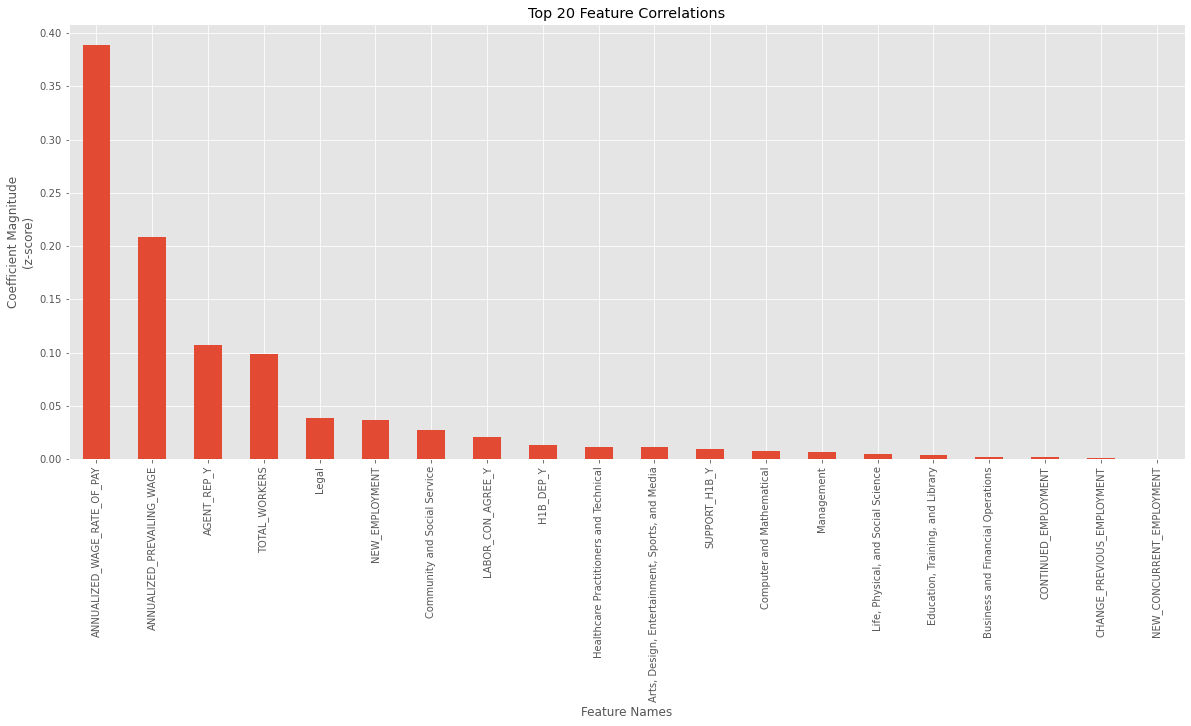

In [125]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = RFS_ft_imp_df.head(20)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top 20 Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

The most influential features affecting processing time are annualized wage rate of pay and annualized prevailing wage.  This mamkes sense as one of the main criteria in certifying the application is that the wage rate of pay must be equal to or above the prevailing wage for the position based on industry and location.

Agent_Rep_Y:  This indicates that applications that were prepared with legal representation moved through the pipeline faster.  This is expected as applications that have legal involvement would be completed accurately.

Total_Workers: An application for 50 workers will undergo more review than an application for one worker.

New_Employment:  Applications for new employment vs. continued employment.  New employment applications indicate that the application is for employment with a new employer.  These likely require more processing time vs. continued employment.  

Labor_Con_Agree_Y indicates the Employer agrees to the responses to the Labor Condition Statements as in the subsection.  

From an occupational group perspective: Legal, Community and Social Service are more influential than other occupational groups. 

# Deployment

### Task1 - Classification

### Task2 - Regression

Current Department of Labor (DOL) processing time for the Labor Condition Application (LCA), a requirement for all H-1B petitions, can take from 5 - 10 days.  Understanding which factors affect certification processing time and estimating the days to process the certification is useful for any business attempting to secure an H1-B Visa, as that process can take from 3 months to 1 year.  These insights can help in workforce planning, especially when reliant on non-US workers.

Value can be measured not only by accurately predicting processing time, but also pinpointing areas that may lengthen the time so that employers can address those prior to submission.

Deployment?

Other data collection ?

How often would the model be updated?

# Exceptional Work

We are looking at the parameters of AdaBoost the learning rate and comparing it to the number of decision trees in the base_estimator. AdaBoost has a base model parameter that specifies the model the boosted ensemble is built from. In this model we use the decision tree as the base model. We try to see the effect of the parameter by changing the number of trees in the base estimator parameter (decision trees) while using a fixed learnig rate of 1.0 and compare it to the results where we change the learning rate parameter and hold the number of trees in the base estimator constant at 1 tree to see which of these parameters has a larger effect on the results.

Both of the parameters do not have a very large effect on the results however we see that the variance in the results is higher in the algorithm with the learning rate constant and the trees varying, the results range from that range from 0.965 for 5 trees to 0.984 for 1 tree, making a variance of 0.019 while for the constant trees algorithm the results ranged from 0.984 for learning rate of 1 to 0.989 for learning rate of 0.6 for a difference of 0.005.

In conclusion we can say that the number of trees in the base estimator parameter has a larger effect on the results than the change in learning rate for the AdaBoost Classifier. 

In [52]:
models = []
models.append(('1.0',AdaBoostClassifier(learning_rate=1.0,base_estimator=DecisionTreeClassifier(max_depth=1),random_state = 42)))
models.append(('0.9',AdaBoostClassifier(learning_rate=0.9,base_estimator=DecisionTreeClassifier(max_depth=1),random_state = 42)))
models.append(('0.8',AdaBoostClassifier(learning_rate=0.8,base_estimator=DecisionTreeClassifier(max_depth=1),random_state = 42)))
models.append(('0.7',AdaBoostClassifier(learning_rate=0.7,base_estimator=DecisionTreeClassifier(max_depth=1),random_state = 42)))
models.append(('0.6',AdaBoostClassifier(learning_rate=0.6,base_estimator=DecisionTreeClassifier(max_depth=1),random_state = 42)))

In [53]:
results = []
names = []
scoring = 'recall'
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, b, a, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

1.0: 0.986650 (0.002484)
0.9: 0.987499 (0.002266)
0.8: 0.987988 (0.002129)
0.7: 0.989030 (0.001721)
0.6: 0.989998 (0.001723)


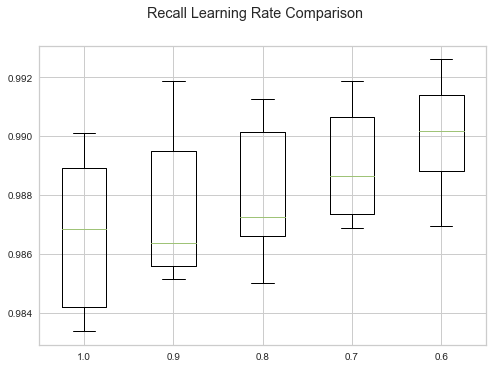

In [54]:
fig = plt.figure()
fig.suptitle('Recall Learning Rate Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [55]:
models = []
models.append(('1tr',AdaBoostClassifier(learning_rate=1.0,base_estimator=DecisionTreeClassifier(max_depth=1),random_state = 42)))
models.append(('2tr',AdaBoostClassifier(learning_rate=1.0,base_estimator=DecisionTreeClassifier(max_depth=2),random_state = 42)))
models.append(('3tr',AdaBoostClassifier(learning_rate=1.0,base_estimator=DecisionTreeClassifier(max_depth=3),random_state = 42)))
models.append(('4tr',AdaBoostClassifier(learning_rate=1.0,base_estimator=DecisionTreeClassifier(max_depth=4),random_state = 42)))
models.append(('5tr',AdaBoostClassifier(learning_rate=1.0,base_estimator=DecisionTreeClassifier(max_depth=5),random_state = 42)))

In [56]:
results = []
names = []
scoring = 'recall'
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, b, a, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

1tr: 0.986650 (0.002484)
2tr: 0.981053 (0.003740)
3tr: 0.978096 (0.003003)
4tr: 0.973143 (0.003370)
5tr: 0.967179 (0.003923)


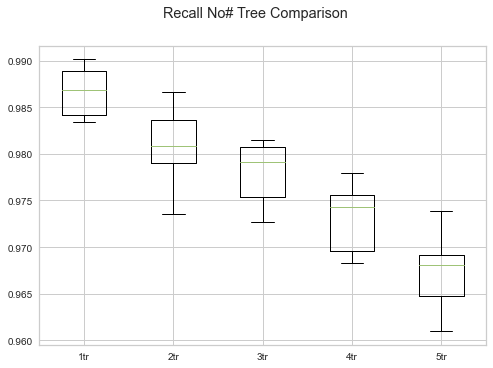

In [57]:
fig = plt.figure()
fig.suptitle('Recall No# Tree Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8

https://scikit-learn.org/stable/modules/feature_selection.html